# **Agent Memory**

**Review**

Previously, we built an agent that can:

**act** - let the model call specific tools

**observe** - pass the tool output back to the model

**reason** - let the model reason about the tool output to decide what to do next (e.g., call another tool or just respond directly)

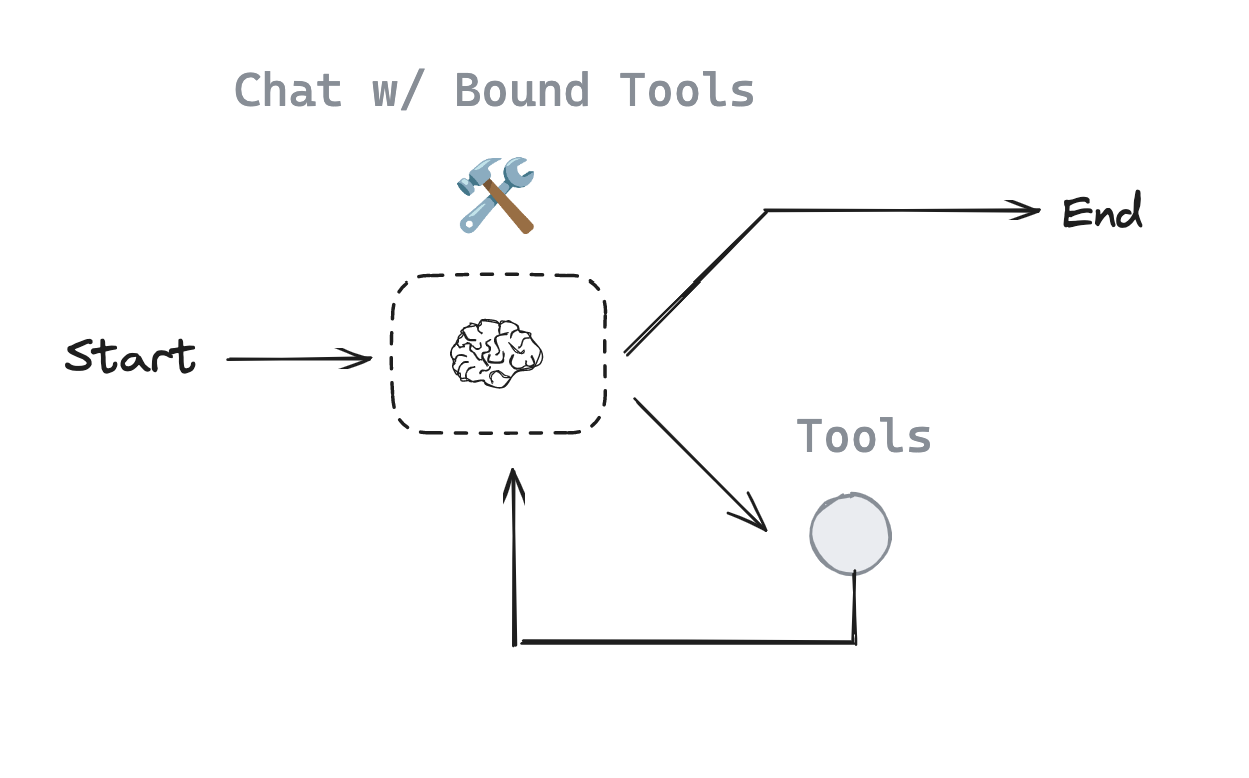

**Goal**

Now, we're going extend our agent by introducing memory.

In [1]:
%%capture --no-stderr
%pip install --quiet -U langchain_google_genai langchain_core langgraph

In [2]:
import os
from google.colab import userdata
GOOGLE_API_KEY=userdata.get('GOOGLE_API_KEY')
os.environ["GOOGLE_API_KEY"]=GOOGLE_API_KEY

In [3]:
# Tools
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

In [10]:
from langchain_google_genai import ChatGoogleGenerativeAI
llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash")
llm.invoke("Hello Gemini!")

AIMessage(content='Hello there!  How can I help you today?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-26b18c6f-5966-488a-b864-9011e3777bc7-0', usage_metadata={'input_tokens': 3, 'output_tokens': 12, 'total_tokens': 15, 'input_token_details': {'cache_read': 0}})

In [11]:
# Binding LLM with tool
tools = [multiply, add, divide]
llm_with_tool = llm.bind_tools(tools)

In [12]:
llm_with_tool.invoke("Multiply 2 with 3.")

AIMessage(content='', additional_kwargs={'function_call': {'name': 'multiply', 'arguments': '{"a": 2.0, "b": 3.0}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-691f62cc-ee57-48ce-b4b6-4d831c3cab84-0', tool_calls=[{'name': 'multiply', 'args': {'a': 2.0, 'b': 3.0}, 'id': 'cae1cc9a-5564-4127-b78c-9f91f25a2dc3', 'type': 'tool_call'}], usage_metadata={'input_tokens': 49, 'output_tokens': 3, 'total_tokens': 52, 'input_token_details': {'cache_read': 0}})

# **Agent Architecture**

In [15]:
from langgraph.graph import MessagesState
from langchain_core.messages import AIMessage, SystemMessage, HumanMessage

In [27]:
# Designing a Assistant Node
sys_msg = SystemMessage(content="You are an helpful assistant and help to solve user query related to arithmatic operations and also general questions.")

# Node
def assistant(state: MessagesState) -> MessagesState:
  return {"messages": [llm_with_tool.invoke([sys_msg] + state["messages"])]}

In [28]:
from langgraph.graph import START, END, StateGraph
from langgraph.prebuilt import ToolNode, tools_condition
# Building the workflow
builder = StateGraph(MessagesState)

# Add node
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Add Edges
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    tools_condition
)
builder.add_edge("tools", "assistant")

# Compile
react_graph = builder.compile()

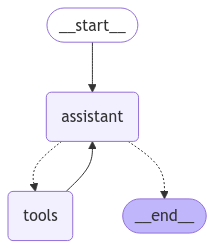

In [29]:
from IPython.display import Image, display
display(Image(react_graph.get_graph().draw_mermaid_png()))

In [30]:
# invoke
messages = react_graph.invoke({"messages": "Multiply 2 and 3."})
for msg in messages["messages"]:
  msg.pretty_print()

================================ Human Message =================================

Multiply 2 and 3.
================================== Ai Message ==================================
Tool Calls:
  multiply (846ed0d3-b197-47bb-964c-227aa1677d98)
 Call ID: 846ed0d3-b197-47bb-964c-227aa1677d98
  Args:
    a: 2.0
    b: 3.0
================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================

The result of multiplying 2 and 3 is 6.


In [31]:
# invoke
messages = react_graph.invoke({"messages": "Add 6 to it."})
for msg in messages["messages"]:
  msg.pretty_print()

================================ Human Message =================================

Add 6 to it.
================================== Ai Message ==================================

Add 6 to what? Please provide the number you want to add 6 to.


**Memory**

**Transient State vs. Steady State**

In computing and system behavior, we often encounter two states: transient and steady.

**Transient State**:

- **Definition**: Transient state refers to the moments right after a change occurs. It's a temporary, dynamic condition.
- **Example**: When you start a new chat session, your memory is transient—you're catching up, refreshing your context, and getting back into the conversation groove.

**Steady State**:

- **Definition**: Steady state represents a stable, predictable condition. It's when a system settles into an equilibrium.
- **Example**: As our chat progresses and we remember details from earlier conversations, we move toward a steady state.
Remember, in a single chat session (or graph execution), we experience both transient and steady states. Each interaction contributes to our overall understanding.

In [32]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()
react_graph_memory = builder.compile(checkpointer=memory)

When we use memory, we need to specify a **thread_id**.

This **thread_id** will store our memory location of graph states collection.

Here is a cartoon:

- The checkpointer write the state at every step of the graph
- These checkpoints are saved in a thread
- We can access that thread in the future using the **thread_id**

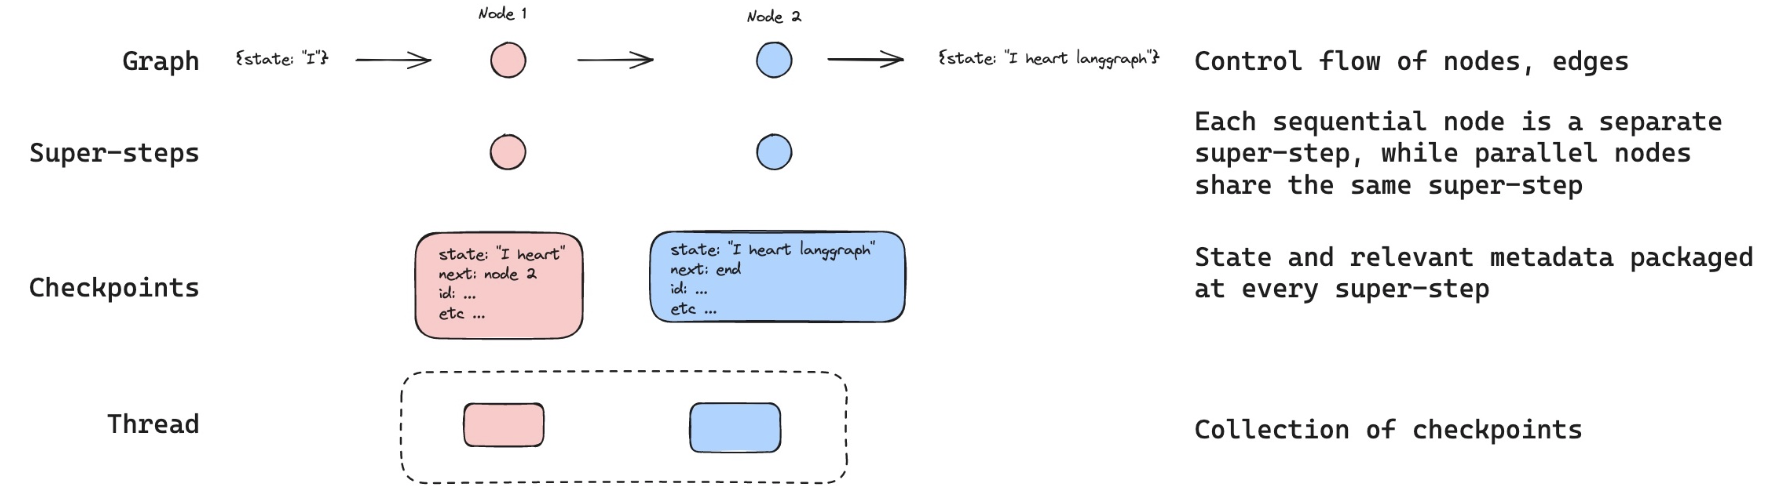

In [33]:
# Specify a thread
config = {"configurable": {"thread_id": "1"}}

In [34]:
# Specify an input
input = HumanMessage(content="add 2 and 3.")

messages = react_graph_memory.invoke({"messages": input}, config)
for msg in messages['messages']:
  msg.pretty_print()

================================ Human Message =================================

add 2 and 3.
================================== Ai Message ==================================
Tool Calls:
  add (9f5c88af-8381-489e-bd69-50bf8e4d52fd)
 Call ID: 9f5c88af-8381-489e-bd69-50bf8e4d52fd
  Args:
    a: 2.0
    b: 3.0
================================= Tool Message =================================
Name: add

5
================================== Ai Message ==================================

The sum of 2 and 3 is 5.


In [35]:
messages = [HumanMessage(content="Multiply that by 2.")]
messages = react_graph_memory.invoke({"messages": messages}, config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

add 2 and 3.
================================== Ai Message ==================================
Tool Calls:
  add (9f5c88af-8381-489e-bd69-50bf8e4d52fd)
 Call ID: 9f5c88af-8381-489e-bd69-50bf8e4d52fd
  Args:
    a: 2.0
    b: 3.0
================================= Tool Message =================================
Name: add

5
================================== Ai Message ==================================

The sum of 2 and 3 is 5.
================================ Human Message =================================

Multiply that by 2.
================================== Ai Message ==================================
Tool Calls:
  multiply (f3dd4cf2-24b3-4845-819d-b1c6ddaa084e)
 Call ID: f3dd4cf2-24b3-4845-819d-b1c6ddaa084e
  Args:
    a: 5.0
    b: 2.0
================================= Tool Message =================================
Name: multiply

10
================================== Ai Message =====================